In [ ]:
!pip install -q transformers datasets torch scikit-learn pandas accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import numpy as np
import re
import os

In [ ]:
MODEL_NAME = 'roberta-base'
INPUT_CSV_FILE = '/content/drive/MyDrive/ML_Models/DATASET/Final_Comments_Dataset.csv'
GOOGLE_DRIVE_BASE_PATH = '/content/drive/MyDrive/ML_Models'

CURRENT_TASK_TYPE = 'emotion'


if CURRENT_TASK_TYPE == 'sentiment':
    TEXT_COLUMN = 'comment'
    LABEL_COLUMN = 'sentiment'
    SENTIMENT_LABELS = ['positive', 'negative', 'neutral']
    NUM_LABELS = len(SENTIMENT_LABELS)
    MODEL_OUTPUT_DIR = os.path.join(GOOGLE_DRIVE_BASE_PATH, 'results_sentiment')
    SAVED_MODEL_DIR = os.path.join(GOOGLE_DRIVE_BASE_PATH, 'saved_model_sentiment')
elif CURRENT_TASK_TYPE == 'emotion':
    TEXT_COLUMN = 'comment'
    LABEL_COLUMN = 'emotion'

    EMOTION_LABELS_FROM_USER = [
        "joy", "sadness", "anger", "fear", "disgust", "surprise", "neutral"
    ]
    NUM_LABELS = len(EMOTION_LABELS_FROM_USER)
    MODEL_OUTPUT_DIR = os.path.join(GOOGLE_DRIVE_BASE_PATH, 'results_emotion')
    SAVED_MODEL_DIR = os.path.join(GOOGLE_DRIVE_BASE_PATH, 'saved_model_emotion')
else:
    raise ValueError("CURRENT_TASK_TYPE must be 'sentiment' or 'emotion'")

# Ensure the output directories exist
if GOOGLE_DRIVE_BASE_PATH.startswith('/content/drive'):
    if not os.path.exists(MODEL_OUTPUT_DIR):
        os.makedirs(MODEL_OUTPUT_DIR)
        print(f"Created directory: {MODEL_OUTPUT_DIR}")
    if not os.path.exists(SAVED_MODEL_DIR):
        os.makedirs(SAVED_MODEL_DIR)
        print(f"Created directory: {SAVED_MODEL_DIR}")
else:
    print(f"Warning: GOOGLE_DRIVE_BASE_PATH ('{GOOGLE_DRIVE_BASE_PATH}') does not seem to be a Google Drive path. Model saving might be local to Colab session if Drive is not mounted and path not adjusted.")

def clean_emotion_label(label):
    if pd.isna(label):
        return None
    cleaned_label = re.sub(r'[^\w\s,]', '', str(label)).strip()
    parts = cleaned_label.split()
    if parts:
        return parts[0].lower()
    return cleaned_label.lower()

Created directory: /content/drive/MyDrive/ML_Models/results_emotion


In [ ]:
# Step 2: Load and Prepare Data
print(f"Loading data from {INPUT_CSV_FILE} for {CURRENT_TASK_TYPE} task...")
try:
    df = pd.read_csv(INPUT_CSV_FILE)
except FileNotFoundError:
    print(f"Error: {INPUT_CSV_FILE} not found. Please upload it to your Colab session.")
    exit()
except Exception as e:
    print(f"Error reading CSV: {e}")
    exit()

# --- Data Cleaning and Preprocessing ---
print("Preprocessing data...")
df.dropna(subset=[TEXT_COLUMN, LABEL_COLUMN], inplace=True)
df[TEXT_COLUMN] = df[TEXT_COLUMN].astype(str)

if CURRENT_TASK_TYPE == 'sentiment':
    df[LABEL_COLUMN] = df[LABEL_COLUMN].str.lower()
    df = df[df[LABEL_COLUMN].isin([l.lower() for l in SENTIMENT_LABELS])]
    label_map = {label: i for i, label in enumerate(SENTIMENT_LABELS)}
    df['label_id'] = df[LABEL_COLUMN].map(label_map)

elif CURRENT_TASK_TYPE == 'emotion':
    df[LABEL_COLUMN] = df[LABEL_COLUMN].apply(clean_emotion_label)
    df.dropna(subset=[LABEL_COLUMN], inplace=True)
    df = df[df[LABEL_COLUMN].isin([l.lower() for l in EMOTION_LABELS_FROM_USER])]
    label_map = {label: i for i, label in enumerate(EMOTION_LABELS_FROM_USER)}
    df['label_id'] = df[LABEL_COLUMN].map(label_map)

if df.empty or 'label_id' not in df.columns or df['label_id'].isna().all():
    print("Error: No valid data remaining after preprocessing and label mapping. Check your CSV and label definitions.")
    if not df.empty and 'label_id' in df.columns:
        print(f"Label ID counts before error: {df['label_id'].value_counts(dropna=False)}")
    exit()

df.dropna(subset=['label_id'], inplace=True)
df['label_id'] = df['label_id'].astype(int)

print(f"Data shapes after cleaning: {df.shape}")
print(f"Label distribution:\n{df[LABEL_COLUMN].value_counts()}")
print(f"Label ID distribution:\n{df['label_id'].value_counts()}")

Loading data from /content/drive/MyDrive/ML_Models/DATASET/Final_Comments_Dataset.csv for emotion task...
Preprocessing data...
Data shapes after cleaning: (70553, 7)
Label distribution:
emotion
neutral     30532
joy         14292
surprise     9790
sadness      5488
anger        3882
disgust      3531
fear         3038
Name: count, dtype: int64
Label ID distribution:
label_id
6    30532
0    14292
5     9790
1     5488
2     3882
4     3531
3     3038
Name: count, dtype: int64


In [ ]:
print("Tokenizing data...")
tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples[TEXT_COLUMN], padding="max_length", truncation=True, max_length=128)

hg_dataset = Dataset.from_pandas(df[[TEXT_COLUMN, 'label_id']].rename(columns={'label_id': 'labels'}))

# Tokenize the dataset
tokenized_dataset = hg_dataset.map(tokenize_function, batched=True)


if len(tokenized_dataset) < 20:
    print("Warning: Dataset is very small. Using a larger portion for training or all data if less than a few samples for eval.")
    if len(tokenized_dataset) <= 2:
        train_dataset = tokenized_dataset
        eval_dataset = tokenized_dataset
        print("Dataset too small to split meaningfully. Using all data for training and evaluation.")
    else:
        split_datasets = tokenized_dataset.train_test_split(test_size=max(1, int(len(tokenized_dataset)*0.1)), shuffle=True, seed=42)
        train_dataset = split_datasets['train']
        eval_dataset = split_datasets['test']
else:
    split_datasets = tokenized_dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)
    train_dataset = split_datasets['train']
    eval_dataset = split_datasets['test']


dataset_dict = DatasetDict({
    'train': train_dataset,
    'eval': eval_dataset
})

print(f"Training dataset size: {len(dataset_dict['train'])}")
print(f"Evaluation dataset size: {len(dataset_dict['eval'])}")


Tokenizing data...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/70553 [00:00<?, ? examples/s]

Training dataset size: 56442
Evaluation dataset size: 14111


In [ ]:
# Step 4: Model Loading & Training
print("Loading pre-trained model...")
model = RobertaForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label={i: label for i, label in enumerate(label_map.keys())}, # For inference label names
    label2id=label_map
)

# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted') # Use 'weighted' for multi-class
    return {
        'accuracy': acc,
        'f1': f1,
    }

print("Setting up training arguments...")

training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_DIR,
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=os.path.join(GOOGLE_DRIVE_BASE_PATH, 'logs', CURRENT_TASK_TYPE.lower()),
    logging_steps=200,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=torch.cuda.is_available(),
    learning_rate=2e-5,
)

# Ensure logging directory exists
if GOOGLE_DRIVE_BASE_PATH.startswith('/content/drive'): # Only create if Google Drive path is intended
    if not os.path.exists(training_args.logging_dir):
        os.makedirs(training_args.logging_dir)
        print(f"Created logging directory: {training_args.logging_dir}")


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['eval'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

print(f"Starting training for {CURRENT_TASK_TYPE} task...")
try:
    trainer.train()
except Exception as e:
    print(f"An error occurred during training: {e}")
    exit()

print("Training complete.")


Loading pre-trained model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-ef32565566ad>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Setting up training arguments...
Created logging directory: /content/drive/MyDrive/ML_Models/logs/emotion
Starting training for emotion task...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.613700,0.570546,0.791298,0.789923
2,0.424400,0.527803,0.808518,0.809249


Training complete.


In [ ]:
# Step 5: Evaluation
print("Evaluating model...")
eval_results = trainer.evaluate()
print(f"Evaluation results for {CURRENT_TASK_TYPE}:\n{eval_results}")

# Step 6: Saving the Model
print(f"Saving fine-tuned model to {SAVED_MODEL_DIR}...")
trainer.save_model(SAVED_MODEL_DIR)
tokenizer.save_pretrained(SAVED_MODEL_DIR) # Save tokenizer with the model
print("Model and tokenizer saved.")

# Step 7: Prediction Example (How to use the fine-tuned model)
# Load the saved model and tokenizer for inference
print("\n--- Prediction Example ---")
if CURRENT_TASK_TYPE == 'sentiment':
    # Ensure correct mapping based on how label_map was created
    id2label_map = {v: k for k, v in label_map.items()}
elif CURRENT_TASK_TYPE == 'emotion':
     # Ensure correct mapping based on how label_map was created
    id2label_map = {v: k for k, v in label_map.items()}

Evaluating model...


Evaluation results for emotion:
{'eval_loss': 0.5278027653694153, 'eval_accuracy': 0.8085181773084827, 'eval_f1': 0.8092491986927204, 'eval_runtime': 6.0802, 'eval_samples_per_second': 2320.819, 'eval_steps_per_second': 36.348, 'epoch': 2.0}
Saving fine-tuned model to /content/drive/MyDrive/ML_Models/saved_model_emotion...
Model and tokenizer saved.

--- Prediction Example ---


In [ ]:
!pip install -q transformers datasets torch scikit-learn pandas accelerate

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from tqdm import tqdm
import warnings

In [ ]:
warnings.filterwarnings('ignore')

print("--- Loading and Preprocessing Data ---")
try:
    df = pd.read_csv('Final_Comments_Dataset.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'Final_Comments_Dataset.csv' not found.")
    print("Please make sure the dataset file is in the same directory as this script.")
    exit()

df.dropna(subset=['comment', 'emotion', 'sentiment', 'like_count'], inplace=True)

df['text_input'] = df['comment'].astype(str) + ' [SEP] ' + df['emotion'].astype(str) + ' [SEP] ' + df['sentiment'].astype(str)

df['like_count'] = pd.to_numeric(df['like_count'], errors='coerce')
df.dropna(subset=['like_count'], inplace=True)
df['like_count'] = df['like_count'].astype(int)

# For faster demonstration, we can use a sample.
# Comment out the next line to run on the full dataset.
# df = df.sample(n=min(len(df), 2000), random_state=42)
# print(f"Proceeding with {len(df)} rows.")

--- Loading and Preprocessing Data ---
Dataset loaded successfully.
Proceeding with 2000 rows.


In [ ]:
# --- 2. BERT EMBEDDING GENERATION ---
print("\n--- Initializing BERT Model ---")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

def get_bert_embeddings(texts, batch_size=64):
    model.eval()
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
        batch_texts = texts[i:i+batch_size].tolist()
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.extend(cls_embeddings)
    return np.array(all_embeddings)

X_embeddings = get_bert_embeddings(df['text_input'])
y_labels = df['like_count'].values

# --- 3. SAVE THE RESULTS ---
print("\n--- Saving embeddings and labels ---")
np.save('bert_embeddings.npy', X_embeddings)
np.save('labels.npy', y_labels)

print("\n✅ Process Complete!")
print(f"Embeddings saved to 'bert_embeddings.npy' (Shape: {X_embeddings.shape})")
print(f"Labels saved to 'labels.npy' (Shape: {y_labels.shape})")


--- Initializing BERT Model ---
Using device: cuda


Generating Embeddings: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


--- Saving embeddings and labels ---

✅ Process Complete!
Embeddings saved to 'bert_embeddings.npy' (Shape: (2000, 768))
Labels saved to 'labels.npy' (Shape: (2000,))
You can now download these two files and switch to a CPU session.


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json
import warnings

warnings.filterwarnings('ignore')

# --- 0. INSTALL XGBOOST ---
!pip install xgboost

# --- 1. LOAD PRE-COMPUTED EMBEDDINGS ---
print("\n--- Loading pre-computed embeddings and labels ---")
try:
    X_embeddings = np.load('bert_embeddings.npy')
    y_labels = np.load('labels.npy')
    print("✅ Files loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'bert_embeddings.npy' or 'labels.npy' not found.")
    exit()

# --- 2. SPLIT DATA FOR TRAINING AND TESTING ---
X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings,
    y_labels,
    test_size=0.2,
    random_state=42
)
print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.")

print("\n--- Starting Hyperparameter Tuning ---")
param_dist = {
    'objective': ['reg:squarederror', 'reg:absoluteerror'],
    'n_estimators': [100, 200, 300, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10, 15],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0],
}
xgbr = xgb.XGBRegressor(random_state=42, tree_method='gpu_hist')
random_search = RandomizedSearchCV(
    estimator=xgbr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
random_search.fit(X_train, y_train)

print("\nBest hyperparameters found:")
print(random_search.best_params_)
best_model = random_search.best_estimator_

# --- 4. EVALUATE THE BEST MODEL ON THE TEST SET ---
print("\n--- Evaluating the best model ---")
# Get predictions on the test data
y_pred = best_model.predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse) # Root Mean Squared Error

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# --- 5. SAVE THE RESULTS ---
print("\n--- Saving results ---")
# Save the model itself
joblib.dump(best_model, 'xgboost_regressor_model.pkl')
print("✅ Model saved to 'xgboost_regressor_model.pkl'")

# Create a dictionary for the evaluation scores
evaluation_results = {
    'best_hyperparameters': random_search.best_params_,
    'mae': mae,
    'mse': mse,
    'rmse': rmse,
    'r2_score': r2
}

# Save the scores to a JSON file
with open('regression_evaluation.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)
print("✅ Evaluation metrics saved to 'regression_evaluation.json'")


--- Loading pre-computed embeddings and labels ---
✅ Files loaded successfully.
Data split into 56442 training samples and 14111 testing samples.

--- Starting Hyperparameter Tuning with XGBoost on GPU ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best hyperparameters found:
{'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 1.0, 'objective': 'reg:absoluteerror', 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}

--- Evaluating the best model ---
Mean Absolute Error (MAE): 1369.1423
Mean Squared Error (MSE): 60987408.0000
Root Mean Squared Error (RMSE): 7809.4435
R-squared (R²): -0.0229

--- Saving results ---
✅ Model saved to 'xgboost_regressor_model.pkl'
✅ Evaluation metrics saved to 'regression_evaluation.json'


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import joblib
import warnings

warnings.filterwarnings('ignore')

# --- 0. Install necessary libraries ---
# Make sure xgboost is installed in the environment
!pip install xgboost

# --- 1. Load and Prepare the Data ---
try:
    df = pd.read_csv('Final_Comments_Dataset.csv')
    print("✅ Dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'Final_Comments_Dataset.csv' not found. Please make sure the file is uploaded.")
    exit()

# Drop rows where 'Comment' or 'like_count' is missing, as they are essential
df.dropna(subset=['comment', 'like_count'], inplace=True)

# Ensure 'like_count' is a numeric type, converting errors to NaN and then filling with 0
df['like_count'] = pd.to_numeric(df['like_count'], errors='coerce').fillna(0)


# Define our features (X) and target (y)
X = df['comment']
y = df['like_count']

# --- 2. Split Data for Training and Testing ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining on {len(X_train)} samples and testing on {len(X_test)} samples.")

# --- 3. Create Model Pipeline and Hyperparameter Grid ---
# A pipeline streamlines the workflow by chaining the text vectorizer and the regressor.
model_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2))
    ),
    ('regressor', xgb.XGBRegressor(
        random_state=42,
        objective='reg:squarederror',
        tree_method='gpu_hist', # This line enables GPU acceleration
        n_jobs=-1))
])

# Define the grid of hyperparameters to search through
param_dist = {
    'tfidf__max_features': [3000, 5000, 7000],
    'regressor__n_estimators': [100, 200, 300, 500],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# --- 4. Perform Randomized Search for Hyperparameter Tuning ---
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings that are sampled. Increase for better results.
    cv=3,       # Number of cross-validation folds.
    scoring='neg_mean_absolute_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("\nStarting hyperparameter tuning with RandomizedSearchCV...")
random_search.fit(X_train, y_train)

# The best pipeline found by the search
best_model = random_search.best_estimator_

print("\n✅ Hyperparameter tuning complete.")
print("\nBest parameters found:")
print(random_search.best_params_)


# --- 5. Evaluate for Overfitting ---
print("\n--- Checking for Overfitting ---")

# Evaluate on the Test Set (unseen data)
print("\n--- Performance on Test Set ---")
y_pred_test = best_model.predict(X_test)
y_pred_test[y_pred_test < 0] = 0
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
print(f"Test MAE: {mae_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test R²: {r2_test:.4f}")

# Evaluate on the Training Set (seen data)
print("\n--- Performance on Training Set ---")
y_pred_train = best_model.predict(X_train)
y_pred_train[y_pred_train < 0] = 0
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)
print(f"Train MAE: {mae_train:.2f}")
print(f"Train RMSE: {rmse_train:.2f}")
print(f"Train R²: {r2_train:.4f}")

# --- 6. Show an Example Prediction ---
print("\n\n--- Example Prediction with Best Model ---")
example_index = 15
sample_comment = X_test.iloc[example_index]
actual_likes = y_test.iloc[example_index]
predicted_likes = best_model.predict([sample_comment])[0]
predicted_likes = max(0, predicted_likes)

print(f"\nSample Comment: '{sample_comment}'")
print(f"Actual Like Count: {int(actual_likes)}")
print(f"Predicted Like Count: {predicted_likes:.2f}")

# --- 7. Save the Best Model to a File ---
model_filename = 'like_predictor_xgboost.pkl'
print(f"\n\n--- Saving the best model to {model_filename} ---")
joblib.dump(best_model, model_filename)
print(f"✅ Model saved successfully.")


✅ Dataset loaded successfully.

Training on 56442 samples and testing on 14111 samples.

Starting hyperparameter tuning with RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Hyperparameter tuning complete.

Best parameters found:
{'tfidf__max_features': 5000, 'regressor__subsample': 1.0, 'regressor__n_estimators': 500, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.01, 'regressor__colsample_bytree': 0.9}

--- Checking for Overfitting ---

--- Performance on Test Set ---
Test MAE: 1925.09
Test RMSE: 7728.35
Test R²: -0.0018

--- Performance on Training Set ---
Train MAE: 1855.68
Train RMSE: 6427.33
Train R²: 0.0403


--- Example Prediction with Best Model ---

Sample Comment: 'Techno I want see you 😢'
Actual Like Count: 0
Predicted Like Count: 1346.04


--- Saving the best model to like_predictor_xgboost.pkl ---
✅ Model saved successfully.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted. Looking for models in: /content/drive/MyDrive/ML_Models
--- Loading Saved Models ---
✅ Model loaded successfully from /content/drive/MyDrive/ML_Models/saved_model_sentiment
✅ Model loaded successfully from /content/drive/MyDrive/ML_Models/saved_model_emotion

--- Loading and Preprocessing Evaluation Dataset: /content/drive/MyDrive/ML_Models/DATASET/Final_Comments_Dataset.csv ---
Dataset loaded and cleaned. Evaluating on 70553 samples.

--- Generating Predictions for Sentiment Model ---


Generating Predictions: 100%|██████████| 70553/70553 [10:55<00:00, 107.66it/s]



--- Generating Predictions for Emotion Model ---


Generating Predictions: 100%|██████████| 70553/70553 [10:52<00:00, 108.08it/s]



✅ All predictions complete.

--- Evaluation Report for Sentiment Model ---

Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.91      0.92     28153
     neutral       0.79      0.87      0.83      2719
    positive       0.95      0.95      0.95     39681

    accuracy                           0.93     70553
   macro avg       0.89      0.91      0.90     70553
weighted avg       0.93      0.93      0.93     70553

Overall Accuracy: 0.9312

Confusion Matrix:


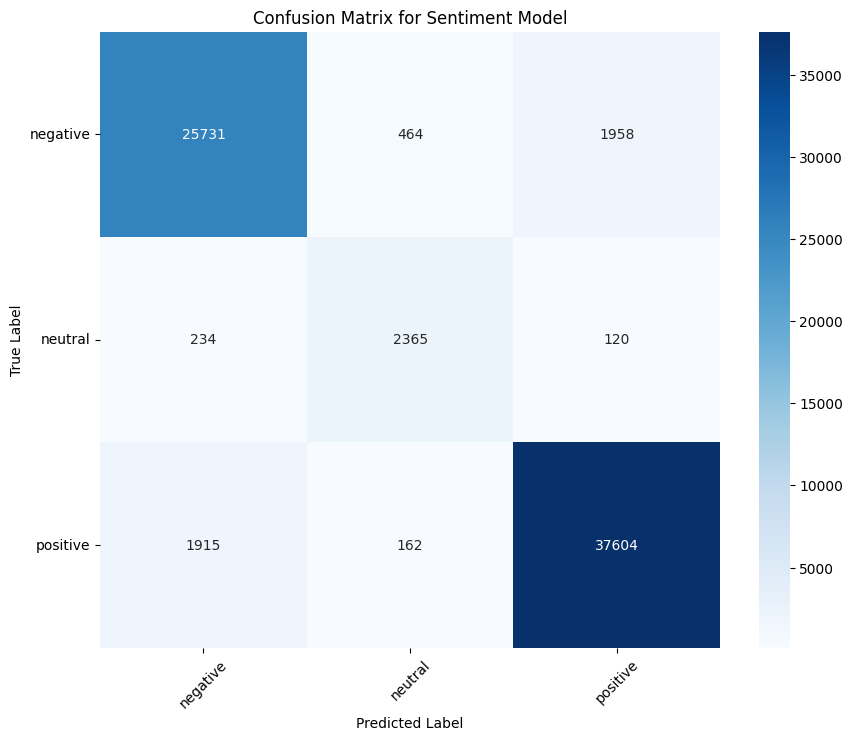


--- Evaluation Report for Emotion Model ---

Classification Report:
              precision    recall  f1-score   support

       anger       0.75      0.80      0.77      3882
     disgust       0.74      0.80      0.77      3531
        fear       0.84      0.80      0.82      3038
         joy       0.88      0.93      0.91     14292
     neutral       0.93      0.88      0.90     30532
     sadness       0.85      0.86      0.85      5488
    surprise       0.84      0.87      0.86      9790

    accuracy                           0.88     70553
   macro avg       0.83      0.85      0.84     70553
weighted avg       0.88      0.88      0.88     70553

Overall Accuracy: 0.8758

Confusion Matrix:


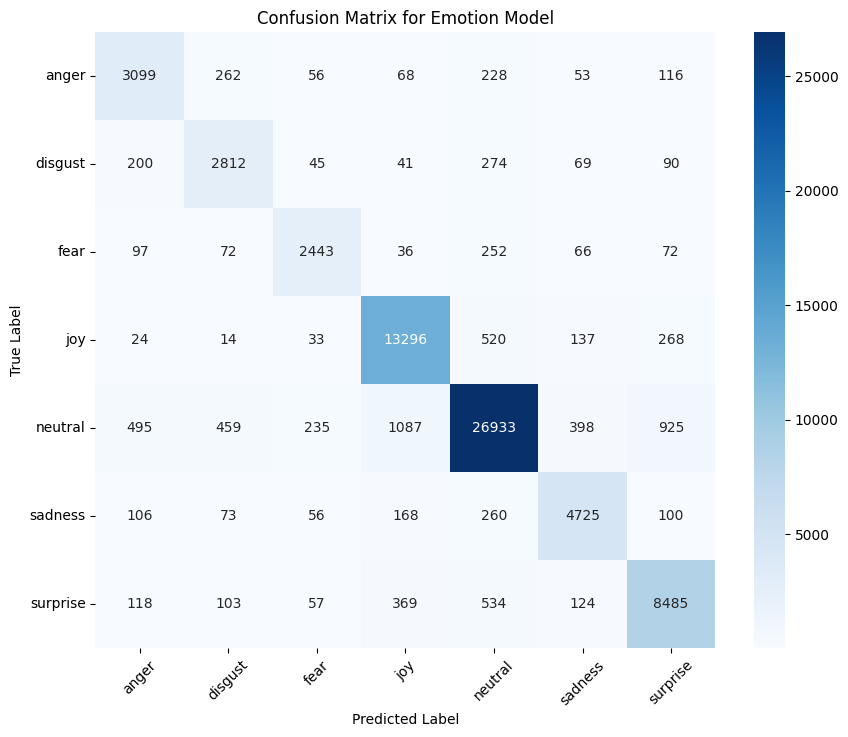

In [ ]:
# Step 1: Install necessary libraries (if not already installed)
# !pip install -q pandas torch transformers accelerate scikit-learn seaborn matplotlib

import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm

# --- Configuration ---
# Paths to saved models
GOOGLE_DRIVE_BASE_PATH = '/content/drive/MyDrive/ML_Models'
SENTIMENT_MODEL_PATH = os.path.join(GOOGLE_DRIVE_BASE_PATH, 'saved_model_sentiment')
EMOTION_MODEL_PATH = os.path.join(GOOGLE_DRIVE_BASE_PATH, 'saved_model_emotion')

# Dataset with ground truth labels
EVALUATION_DATASET_CSV = '/content/drive/MyDrive/ML_Models/DATASET/Final_Comments_Dataset.csv'

# Column names in the dataset (ADJUST IF YOURS ARE DIFFERENT)
TEXT_COLUMN = 'comment'
TRUE_SENTIMENT_COLUMN = 'sentiment'
TRUE_EMOTION_COLUMN = 'emotion'

# --- Mount Google Drive ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print(f"Google Drive mounted. Looking for models in: {GOOGLE_DRIVE_BASE_PATH}")
except ImportError:
    print("Google Colab 'drive' module not found. Assuming not in Colab or Drive already mounted.")
except Exception as e:
    print(f"An error occurred during Google Drive mounting: {e}")

# --- Helper Functions ---
def load_classification_model(model_path):
    """Loads a fine-tuned RoBERTa classification model and tokenizer."""
    if not os.path.exists(model_path) or not os.listdir(model_path):
        print(f"Error: Model not found or directory empty at {model_path}")
        return None, None
    try:
        tokenizer = RobertaTokenizerFast.from_pretrained(model_path)
        model = RobertaForSequenceClassification.from_pretrained(model_path)
        print(f"✅ Model loaded successfully from {model_path}")
        return tokenizer, model
    except Exception as e:
        print(f"❌ Error loading model from {model_path}: {e}")
        return None, None

def clean_emotion_label(label):
    """Cleans emotion labels by removing emojis and standardizing text."""
    if pd.isna(label):
        return None
    cleaned_label = re.sub(r'[^\w\s,]', '', str(label)).strip()
    parts = cleaned_label.split()
    return parts[0].lower() if parts else cleaned_label.lower()

def get_predictions(df, text_column, model, tokenizer):
    """Generates predictions for a dataframe column."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    predictions = []
    texts = df[text_column].tolist()

    for text in tqdm(texts, desc="Generating Predictions"):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        with torch.no_grad():
            logits = model(**inputs).logits
        predicted_class_id = torch.argmax(logits, dim=-1).item()
        predictions.append(model.config.id2label[predicted_class_id])

    return predictions

def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calculates and prints evaluation metrics and plots a confusion matrix."""
    print(f"\n--- Evaluation Report for {model_name} ---")

    # Ensure labels are consistent for the report
    labels = sorted(list(y_true.unique()))

    # Print Classification Report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, labels=labels, zero_division=0)
    print(report)

    # Calculate and Print Overall Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Plot Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# --- Main Evaluation Script ---
def main():
    # --- 1. LOAD MODELS ---
    print("--- Loading Saved Models ---")
    sentiment_tokenizer, sentiment_model = load_classification_model(SENTIMENT_MODEL_PATH)
    emotion_tokenizer, emotion_model = load_classification_model(EMOTION_MODEL_PATH)

    if not all([sentiment_tokenizer, sentiment_model, emotion_tokenizer, emotion_model]):
        print("One or more models failed to load. Aborting evaluation.")
        return

    # --- 2. LOAD AND PREPROCESS DATASET ---
    print(f"\n--- Loading and Preprocessing Evaluation Dataset: {EVALUATION_DATASET_CSV} ---")
    try:
        df_eval = pd.read_csv(EVALUATION_DATASET_CSV)
    except FileNotFoundError:
        print(f"Error: {EVALUATION_DATASET_CSV} not found. Please upload it.")
        return

    # Clean data
    df_eval.dropna(subset=[TEXT_COLUMN, TRUE_SENTIMENT_COLUMN, TRUE_EMOTION_COLUMN], inplace=True)
    df_eval[TEXT_COLUMN] = df_eval[TEXT_COLUMN].astype(str)

    # Standardize ground truth labels
    df_eval['true_sentiment_clean'] = df_eval[TRUE_SENTIMENT_COLUMN].str.lower()
    df_eval['true_emotion_clean'] = df_eval[TRUE_EMOTION_COLUMN].apply(clean_emotion_label)

    print(f"Dataset loaded and cleaned. Evaluating on {len(df_eval)} samples.")

    # --- 3. GET PREDICTIONS ---
    print("\n--- Generating Predictions for Sentiment Model ---")
    df_eval['predicted_sentiment'] = get_predictions(df_eval, TEXT_COLUMN, sentiment_model, sentiment_tokenizer)

    print("\n--- Generating Predictions for Emotion Model ---")
    df_eval['predicted_emotion'] = get_predictions(df_eval, TEXT_COLUMN, emotion_model, emotion_tokenizer)

    print("\n✅ All predictions complete.")

    # --- 4. EVALUATE MODELS ---
    # Evaluate Sentiment Model
    evaluate_model(df_eval['true_sentiment_clean'], df_eval['predicted_sentiment'], "Sentiment Model")

    # Evaluate Emotion Model
    evaluate_model(df_eval['true_emotion_clean'], df_eval['predicted_emotion'], "Emotion Model")

if __name__ == '__main__':
    main()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
